# Viscoelastic flexure of a pedestalled lake (mixed formulation)

## Imports

In [1]:
flexure_type = 'viscoelastic' #can be 'viscoelastic', 'viscous', or 'elastic'
path = f'/home/sermilik/H3F/figures/pedestalled_lake_{flexure_type}' #modify to preferred destination for saving figures

from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os

## Function spaces

In [2]:
nx = 100 #number of elements
Lx = 6000 #length of domain
mesh = IntervalMesh(nx, Lx) #1D mesh
x = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'CG', 2) #function space for deflections
Q2 = FunctionSpace(mesh, 'CG', 2) #and for bending moments
Q = Q1*Q2 #mixed function space for (deflection, bending moment)

η_e, M_e = TrialFunctions(Q) #elastic deflection and bending moment trial functions
η_ν, M_ν = TrialFunctions(Q) #viscous deflection and bending moment trail functions

n_e, m_e = TestFunctions(Q)
n_ν, m_ν = TestFunctions(Q)

q_e, q_ν = Function(Q), Function(Q) #e.g. q_e = (elastic deflection solution, elastic moment solution)

## Material parameters

In [3]:
year = 60*60*24*365.25 #seconds in a year
ρ_i = 910 #icepack's default is 917 kg/m^3
ρ_w = 1032 #icepack's default is 1024 kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
E = 1e9 #Young's Modulus in Pascals
μ = 1/3 #Poisson's Ratio
λ = E/(12*(1 - μ**2)) #1D sum of lame parameters
ν_flex = 5e15/year #flexural viscosity, Pa*s to Pa*yrs
H = 50 #initial uniform thickness (m)

## Choices for flexure solvers

Text(0.5, 0, 'longitudinal coordinate (m)')

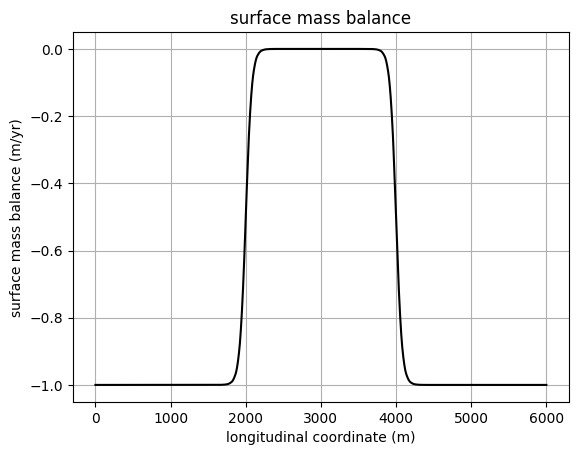

In [4]:
############################
############################
### timestepping choices ###
############################
############################

Δt = 1 #length of timestep in years
num_timesteps = int(20/Δt) #spin up for 20 years

############################################
############################################
### initialize stuff for flexure solver ####
############################################
############################################

Ση_e, Ση_νΔt = Function(Q1).project(Constant(0)), Function(Q1).project(Constant(0)) #net deflections to date
ΣM_e, ΣM_ν = Function(Q2).project(Constant(0)), Function(Q2).project(Constant(0)) #net moments to date

bc_M = DirichletBC(Q.sub(1), Constant(0), (1, 2)) #will use this BC to impose M = 0 on both boundaries

#############################################
#############################################
### determine geometry of the relict lake ###
#############################################
#############################################

r = 1000 #radius of the relict lake
px = Lx/2 #initial center coordinate of the lake
γ = 1/40
smb = Function(Q1).project(-1 + 1/(1 + exp(-γ*(x[0] - px + r))) - 1/(1 + exp(-γ*(x[0] - px - r)))) #see output below

########################################
########################################
### define and plot initial geometry ###
########################################
########################################

os.chdir(path) #for saving figures
X = np.arange(0, Lx+1, 1) #along-flow line for getting geometry profiles
s = Function(Q2).project(Constant((1 - ϱ)*H)) #surface elevation begins at equilibrium
b = Function(Q2).project(Constant(-ϱ*H)) #basal elevation begins at equilibrium
H = Function(Q2).project(s - b)
s_profile = s.at(X, tolerance = 1e-10)
b_profile = project(b + 25, Q2).at(X, tolerance = 1e-10) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s_profile, color='red', label = 'surface')
plt.plot(b_profile, color='blue', label = 'base + 25 m')
plt.legend(loc = 'lower left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(-20, 10)
plt.xticks(np.arange(0, Lx+1, 1000))
plt.grid(linewidth=0.2)
plt.savefig('iteration_0')
plt.close() #comment out to actually see the plot

plt.figure()
plt.title('surface mass balance')
plt.plot(smb.at(X, tolerance = 1e-10), color = 'k')
plt.grid()
plt.ylabel('surface mass balance (m/yr)')
plt.xlabel('longitudinal coordinate (m)')

## Solve and plot

In [ ]:
for step in range(num_timesteps):

    ##################################
    ##################################
    ### apply surface mass balance ###
    ##################################
    ##################################

    s = Function(Q1).project(s + smb*Δt)
    H = Function(Q1).project(H + smb*Δt)

    #######################
    #######################
    ### viscous flexure ###
    #######################
    #######################

    if flexure_type in ['viscous', 'viscoelastic']:
    
        a = grad(m_ν)[0]*grad(M_ν)[0]*dx + n_ν*M_ν*dx - grad(1/3*ν_flex*H**3*n_ν)[0]*grad(η_ν)[0]*dx + ρ_w*g*η_ν*Δt*m_ν*dx
        L = ρ_w*g*((1 - ϱ)*H - s)*m_ν*dx
    
        solve(a == L, q_ν, bcs = bc_M) #q_ν[0] in m/yr, q_ν[1] in Newtons
        
        b = project(b + q_ν[0]*Δt, Q1) #b is modified by the deflection
        s = project(s + q_ν[0]*Δt, Q1) #s is modified by deflection and surface mass balance
        H = project(s - b, Q1)

    #######################
    #######################
    ### elastic flexure ###
    #######################
    #######################
    
    if flexure_type in ['elastic', 'viscoelastic']:

        a = grad(m_e)[0]*grad(M_e)[0]*dx + n_e*M_e*dx - grad(H**3*λ*n_e)[0]*grad(η_e)[0]*dx + ρ_w*g*η_e*m_e*dx
        L = ρ_w*g*((1 - ϱ)*H - s)*m_e*dx - grad(m_e)[0]*grad(ΣM_e)[0]*dx  - n_e*ΣM_e*dx
        L += grad(H**3*λ*n_e)[0]*grad(Ση_e)[0]*dx
                
        solve(a == L, q_e, bcs = bc_M) #q_e[0] in meters, q_e[1] in Newtons
        
        b = project(b + q_e[0], Q1) #b is modified by the deflection
        s = project(s + q_e[0], Q1) #s is modified by deflection and surface mass balance 
        H = project(s - b, Q1)

    ##########################################
    ##########################################
    ### update net deflections and moments ###
    ##########################################
    ##########################################

    Ση_e = Function(Q1).project(q_e[0] + Ση_e)
    Ση_νΔt = Function(Q1).project(q_ν[0]*Δt + Ση_νΔt)
    Ση = Function(Q1).project(Ση_e + Ση_νΔt)

    ΣM_e = Function(Q2).project(q_e[1] + ΣM_e)
    ΣM_ν = Function(Q2).project(q_ν[1] + ΣM_ν)
    ΣM = Function(Q2).project(ΣM_e + ΣM_ν)
            
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 25, Q2).at(X, tolerance = 1e-10))
    Ση_profile = np.array(Ση.at(X, tolerance = 1e-10))
    Ση_e_profile = np.array(Ση_e.at(X, tolerance = 1e-10))
    Ση_νΔt_profile = np.array(Ση_νΔt.at(X, tolerance = 1e-10))
    
    plt.figure()
    plt.title(f'centerline profile, $t$ = {step*Δt + Δt:.2f} years, {flexure_type}')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.plot(s_profile, color='red', label = 'surface', linewidth = 3, alpha = 0.5)
    plt.plot(b_profile, color='blue', label = 'base + 25 m', linewidth = 3, alpha = 0.5)
    plt.legend(loc = 'upper left')
    plt.ylim(-20, 10)
    plt.grid(linewidth=0.2)
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

    plt.figure()
    plt.title(f'centerline profile, $t$ = {step*Δt + Δt:.2f} years, {flexure_type}')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('deflection (m)')
    plt.plot(Ση_profile, color = '0.75', linestyle = 'solid', linewidth = 5, label = '$η = η_ν + η_e$')
    plt.plot(Ση_νΔt_profile, color = 'k', linestyle = 'solid', linewidth = 1, label = '$η_ν = Σ\dot{η}_νΔt$', zorder = 100)
    plt.plot(Ση_e_profile, color = 'k', linestyle = 'dashed', linewidth = 1, label = '$η_e$', zorder = 100)
    plt.legend(loc = 'center right')
    plt.ylim(-5, 20)
    plt.grid(linewidth=0.2)
    plt.savefig('deflection_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration 

    if step%10 == 0:
        print(f'{step} out of {num_timesteps} iterations complete')

0 out of 20 iterations complete


In [ ]:
ΣM_profile = ΣM.at(X, tolerance = 1e-10)
ΣM_e_profile = ΣM_e.at(X, tolerance = 1e-10)
ΣM_ν_profile = ΣM_ν.at(X, tolerance = 1e-10)

plt.figure()
plt.title(f'centerline profile, $t$ = {step*Δt + Δt:.2f} years, {flexure_type}')
plt.plot(ΣM_profile, color = '0.75', linestyle = 'solid', linewidth = 5, label = 'net bending moment')
plt.plot(ΣM_ν_profile, color = 'k', linestyle = 'solid', label = 'viscous bending moment')
plt.plot(ΣM_e_profile, color = 'k', linestyle = 'dashed', label = 'elastic bending moment')
plt.legend(loc = 'lower left')
plt.grid(linewidth=0.2)
plt.ylabel('bending moment (N)')
plt.xlabel('longitudinal coordinate (m)')